# MICCAI Educational Challenge (MEC) 2019
# Part 2: Deep Learning Visualization
### By King Chung Ho *, Ratna Sagari Grandhi *, William Speier, Corey Arnold, University of California, Los Angeles, CA, USA
*These authors contributed equally to this work 

- The purpose of this notebook is to illustrate the workflow of applying visualization techniques in understanding the predictions of the deep learning segmentation model. In the visualizations, you will observe that these approaches provide different insights of explaining why a segmentation prediction is made. The visualization techniques include:
  - [1] Saliency Map: Simonyan, Karen, Andrea Vedaldi, and Andrew Zisserman. "Deep inside convolutional networks: Visualising image classification models and saliency maps." arXiv preprint arXiv:1312.6034 (2013).
  - [2] Guided Backpropagation: Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014).
  - [3] Integrated Gradients: Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic attribution for deep networks." Proceedings of the 34th International Conference on Machine Learning-Volume 70. JMLR. org, 2017. 
  - [4] Grad-CAM: Selvaraju, Ramprasaath R., et al. "Grad-CAM: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE International Conference on Computer Vision. 2017.

- This notebook tutorial is based on Part 1, in which a standard UNet is trained for spinal cord white matter and grey matter segmentation. Please refer to Part 1 for details. 

- If you are new to colab, set up GPU usage in colab using this guide: https://hackernoon.com/begin-your-deep-learning-project-for-free-free-gpu-processing-free-storage-free-easy-upload-b4dba18abebc

- Note: we attempt to apply the original implementations based on the papers [1-4]. There could be some discrepancies due to misinterpretations of the mathematical expressions in these papers. We welcome any suggestions to improve the implementations. Feedback is welcome: johnny5550822@g.ucla.edu, sagarigrandhi@g.ucla.edu





# Setup Colab

## Mount a google drive folder

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# checking if mount is successful, i.e. we are able to see the data folder
!ls "/content/drive/My Drive/MICCAI-MEC-2019"

'2017 Spinal cord grey matter segmentation challenge.pdf'   mec
 data							    trained_models


In [0]:
# check RAM, CPU, and GPU
!free -h
!df -BG
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:            12G        8.3G        1.4G         29M        3.1G        9.1G
Swap:            0B          0B          0B
Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G   32G      309G  10% /
tmpfs                 1G    0G        1G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
/dev/sda1           365G   43G      323G  12% /opt/bin
tmpfs                 7G    1G        7G   1% /var/colab
shm                   6G    1G        6G   1% /dev/shm
tmpfs                 7G    0G        7G   0% /proc/acpi
tmpfs                 7G    0G        7G   0% /proc/scsi
tmpfs                 7G    0G        7G   0% /sys/firmware
drive               359G   66G      293G  19% /content/drive
Sat Aug 24 21:41:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Versi

# Install Neccessary Packages

In [0]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install medicaltorch
!pip3 install numpy
!pip3 install pandas
!pip3 install Pillow
!pip3 install scipy

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
from torchvision import transforms, models
from collections import defaultdict
from tqdm import tqdm
from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
from PIL import Image
from matplotlib import cm

import torch.backends.cudnn as cudnn
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # ignore warnings

torch.manual_seed(100)
np.random.seed(100)
cudnn.benchmark = True
%matplotlib inline

# Load Data

In [0]:
# define imaging variables
root_dir = 'drive/My Drive/MICCAI-MEC-2019'
data_train_dir = '%s/data/gm-sc-challenge2017-train' %root_dir
data_test_dir = '%s/data/gm-sc-challenge2017-test' %root_dir

# an example image and its ground truth mask
mri_input_filename = '%s/%s' %(data_train_dir,'site1-sc10-image.nii.gz')
mri_gt_filename = '%s/%s' %(data_train_dir, 'site1-sc10-mask-r1.nii.gz')

In [0]:
# transforms
val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

# dataset
val_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=data_train_dir,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

# loader
val_loader = DataLoader(val_dataset, batch_size=10,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

In [0]:
# get an image and the gt (pytorch tensor)
for i, batch in enumerate(val_loader):
    input_samples, gt_samples = batch["input"], batch["gt"]
    break      
img = input_samples[0,:,:,:][None, :, :, :]
img_gt = gt_samples[0,:,:,:][None, :, :, :]

print(img.shape)
print(img_gt.shape)

torch.Size([1, 1, 200, 200])
torch.Size([1, 1, 200, 200])


# Load the trained model from Part 1


In [0]:
# parameters
trained_model_dir = '%s/trained_models/unet_09_41PM-August-24-2019.pt' %root_dir
model_t = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
model_t.eval()

# load the saved model weights and you can see that the weights
# are the same as the trained model weights. 
model_t.load_state_dict(torch.load(trained_model_dir))
model_t.to("cuda")
for name, param in model_t.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data.shape)
        print(param.data[0])
        break

conv1.conv1.weight
torch.Size([64, 1, 3, 3])
tensor([[[-0.1910, -0.3071, -0.2428],
         [ 0.2693,  0.2706,  0.0847],
         [ 0.0031,  0.3063,  0.2006]]], device='cuda:0')


# Visualization

In [0]:
# define the prediction cutoff
def threshold_predictions(predictions, thr=0.999):
    """
    Define the prediction mask.
    
    :param predictions (torch tensor or numpy): the prediction matrix
    :param thr (float): the value to classify as 1
    """
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

In [0]:
# preprocessing
def preprocess(img, size=(200,200)): 
    """
    Function to preprocess the image.
    
    :param img: pytorch tensor
    :param size: desired size of the resized image; sequence (h,w) or int 
    """ 
    # move the image to GPU
    img=img.to("cuda")
    
    # set the flag to allow gradient computation
    img.requires_grad_()

    return img
img = preprocess(img)
print(img.shape)

torch.Size([1, 1, 200, 200])


## Saliency Map
The purpose of the saliency map is to visualize important areas that contribute to the classification. The methodology to retreiving a saliency map is based on getting the gradients in the backward propagation, followed by the absolute value operation and a max_value normalization.

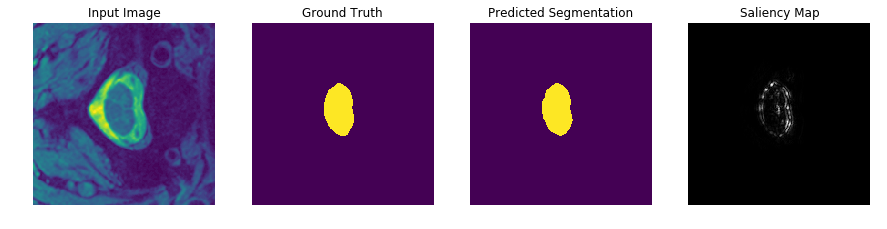

In [0]:
def saliency_map(model, img, img_gt, plot=True):
  """
  Saliency map visualization.
    
  :param model (pytorch Unet): a trained model (pytorch)
  :param img (torch.tensor): preprocessed image with a tensor shape of (C,H,W)
  :param img_gt (torch.tensor): ground truth mask with a tensor shape of (C,H,W)
  :param plot (boolean): whether to plot
  """
  # zero out the existing gradient buffers
  model.zero_grad()
   
  # forward pass 
  scores = model(img)
  
  # predictions
  pred = threshold_predictions(scores.data.cpu().numpy()).astype(np.uint8).squeeze()
    
  # backward pass 
  # Only a scalar is allowed to pass the gradient backward. Therefore we
  # will choose either a sum() operator or a mean() operator
  # https://discuss.pytorch.org/t/loss-backward-raises-error-grad-can-be-implicitly-created-only-for-scalar-outputs/12152
  scores.sum().backward()
    
  # take the absolute value of the image gradients
  grads=torch.abs(img.grad) 
  # normalize the gradients
  grads/=grads.max()

  # remove all dimensions of size-1 from the grads tensor
  grads=torch.squeeze(grads) 
    
  # apply max across all the channels, no need to do it here
  # since we only have 1 channel
  # grads, _ = torch.max(grads, dim=0)

  if plot:
    # display the image and it's saliency map
    fig=plt.figure(figsize=(15, 15))
    
    # original image
    fig.add_subplot(1,4,1)
    plt.imshow(img.cpu().squeeze().detach())
    plt.title('Input Image')
    plt.axis('off') 
    
    # ground truth
    fig.add_subplot(1,4,2)
    plt.imshow(img_gt.squeeze().detach()) 
    plt.title('Ground Truth')
    plt.axis('off')
    
    # prediction
    fig.add_subplot(1,4,3)
    plt.imshow(pred) 
    plt.title('Predicted Segmentation')
    plt.axis('off')
   
    # saliency map
    fig.add_subplot(1,4,4)
    plt.imshow(grads.cpu(),cmap='gray') 
    plt.title('Saliency Map')
    plt.axis('off')
    
  return grads
    
# saliency map visualization
grad = saliency_map(model_t, img, img_gt)


#### Observation: We can notice that the boundary between the GM&WM and subarachnoid space is highlighted by the saliency map (i.e., brighter color). This indicates that the boundary detection in the network is one of the keys to make segmentation predictions. The next method, guided backpropagation, will give a better visualization by clamping the gradients in certain layers.

## Guided Backpropagation
- The difference between saliency map and guided backpropagation is that we need to do clamping in the backward propagation, i.e., make every gradient value at least equal to 0 in a specific layer (usually ReLU layer). In order to calculate the clamped gradient, we need to register a backward hook of pytorch in certain layers. In MedicalTorch, the ReLU layers are  implicitly included in the DownConv module. Therefore, we performed clamping in the DownConv module during backward propagation instead, to illustrate how to do a hook in pytorch.

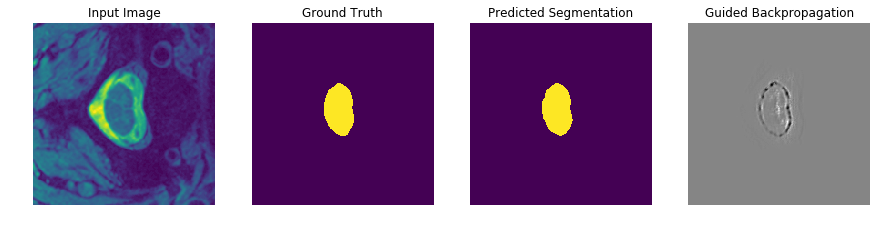

In [0]:
def guided_backward_hook(module, grad_inp, grad_out):
  """
  Hook setup for guided backpropagation.
  
  :param module: nn.Module onto which the hook is registered
  :grad_inp: gradients entering a layer from behind the module
  :grad_out: gradients exiting a layer from the front of the module
  """
  # change all negative input gradients to zero
  return (grad_inp[0].clamp(min=0), grad_inp[1].clamp(min=0), grad_inp[2].clamp(min=0))

def guided_backprop(model):
  """
  Function to loop through the layers of the model and hook certain layers.
  In MedicalTorch, they implicitly put the ReLU into the DownConv module.
  Therefore, we will perform clamping in the DownConv during backward propagation instead.
  
  :param model: any pretrained CNN
  """
  for module in model.modules():
      if isinstance(module, mt_models.DownConv):
        # register the backward hook 
        module.register_backward_hook(guided_backward_hook)


def guided_backpropagation(model, img, img_gt, plot=True):
  """
  Guided backpropagation visualization.
    
  :param model (pytorch Unet): a trained model (pytorch)
  :param img (torch.tensor): preprocessed image with a tensor shape of (C,H,W)
  :param img_gt (torch.tensor): ground truth mask with a tensor shape of (C,H,W)
  :param plot (boolean): whether to plot
  """

  # apply the function to hook ReLUs
  guided_backprop(model)
  
  # zero out the existing gradient buffers
  model.zero_grad()

  # forward pass 
  scores = model(img)
  
  # predictions
  pred = threshold_predictions(scores.data.cpu().numpy()).astype(np.uint8).squeeze()
    
  # backward pass 
  scores.sum().backward()
  
  # get the image gradients
  grads=img.grad

  # remove all dimensions of size-1 from the grads tensor
  grads=torch.squeeze(grads) 
  
  if plot:
    # display the image and it's guided backpropagation
    fig=plt.figure(figsize=(15, 15))
    
    # original image
    fig.add_subplot(1,4,1)
    plt.imshow(img.cpu().squeeze().detach())
    plt.title('Input Image')
    plt.axis('off') 
    
    # ground truth
    fig.add_subplot(1,4,2)
    plt.imshow(img_gt.squeeze().detach()) 
    plt.title('Ground Truth')
    plt.axis('off')
    
    # prediction
    fig.add_subplot(1,4,3)
    plt.imshow(pred) 
    plt.title('Predicted Segmentation')
    plt.axis('off')
  
    # guided backpropagation
    fig.add_subplot(1,4,4)
    plt.imshow(grads.cpu(),cmap='gray') 
    plt.title('Guided Backpropagation')
    plt.axis('off')
    
  return grads
    
# guided backpropagation visualization
grad = guided_backpropagation(model_t, img, img_gt)

#### Observation: Guided backpropagation provides a better visualization than saliency map in highlighting the boundary between the GM&WM and subarachnoid space. This reinforces that the boundary detection in the network is one of the keys to make segmentation predictions. 

## Integrated Gradients

This method relies on integrating the gradients to obtain the visualization of the important regions of the image that contribute to the output prediction. This method is similar to other gradient-based methods (e.g., guided backpropagation), in which the gradient of the output with respect to the input is used to explain a model prediction. The difference between the integrated gradients method and other gradient-based methods is that we integrate (i.e., sum) the gradients of scaled inputs (from certain value to certain value) to obtain the final visualization.

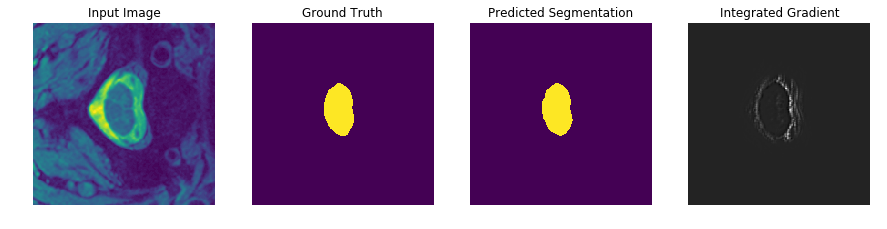

In [0]:
def generate_gradient(model, img):
  """
  Get the gradients from the backward propagation.
  """
  # forward and backward pass
  model.zero_grad()
  scores = model(img)
  scores.sum().backward()
  grad=img.grad.cpu().detach().numpy()
  return grad


def integrated_gradient(model, img, img_gt, baseline=None, steps=50, plot=True):
    """
    Generate integrated gradients.
    
    :param model (pytorch Unet): a trained model (pytorch)
    :param img (torch.tensor): preprocessed image with a tensor shape of (C,H,W)
    :param img_gt (torch.tensor): ground truth mask with a tensor shape of (C,H,W)
    :param baseline (numpy): the baseline reference image
    :param steps (integer): number of steps (blocks) in the gradient calculation
    :param plot (boolean): whether to plot
    """
    # get the prediction score first
    model.zero_grad()
    scores=model(img)
    pred = threshold_predictions(scores.data.cpu().numpy()).astype(np.uint8).squeeze()
    
    # define baseline first
    if baseline is None: 
        baseline = np.zeros(img.shape)
           
    # prepare the scaled images
    imgs = []
    for i in range(0, steps + 1):
        img_new = baseline + (float(i)/steps) * (img.cpu().detach().numpy() - baseline)
        img_new = torch.tensor(img_new).cuda().float()
        img_new.requires_grad_(True)
        imgs.append(img_new)

    # calculate the vanilla gradient for each of the scaled images
    grads = []
    for i in range(0, steps + 1):            
        grad = generate_gradient(model, imgs[i])
        grads.append(grad)
    grads = np.array(grads) #51x1x1x200x200

    # average all the grads
    avg_grad = np.average(grads[:-1], axis=0)

    # get the integrated gradients
    difference = (img.cpu().detach().numpy() - baseline)
    integrated_grad = difference * avg_grad
    integrated_grad = integrated_grad.squeeze()

    if plot:
      # display the image and it's integrated gradients
      fig=plt.figure(figsize=(15, 15))

      # original image
      fig.add_subplot(1,4,1)
      plt.imshow(img.cpu().squeeze().detach())
      plt.title('Input Image')
      plt.axis('off') 

      # ground truth
      fig.add_subplot(1,4,2)
      plt.imshow(img_gt.squeeze().detach()) 
      plt.title('Ground Truth')
      plt.axis('off')

      # prediction
      fig.add_subplot(1,4,3)
      plt.imshow(pred) 
      plt.title('Predicted Segmentation')
      plt.axis('off')

      # integrated gradients
      fig.add_subplot(1,4,4)
      plt.imshow(integrated_grad,cmap='gray') 
      plt.title('Integrated Gradient')
      plt.axis('off')

    return integrated_grad
  
# integrated gradients visualization  
integrated_grad = integrated_gradient(model_t, img, img_gt, steps=50)

#### Observation: Integrated gradients provide similar observations as the guided backpropagation and saliency map, i.e., highlighting the boundary between the GM&WM and subarachnoid space. Both integrated gradients and guided backpropation provide a clearer boundary visualization than the saliency map.

## Grad-CAM
Grad-CAM utilizes the global average pooling operation in the last convolutional layer to identify the weights (importance) of feature maps before the output prediction layer. It works well in identifying regions of the input image that lead to predictions. Grad-CAM has been applied in different deep learning models for medical applications, including interpreting model prediction in chest radiographic studies [1]. 



[1] Irvin, Jeremy, et al. "Chexpert: A large chest radiograph dataset with uncertainty labels and expert comparison." arXiv preprint arXiv:1901.07031 (2019).

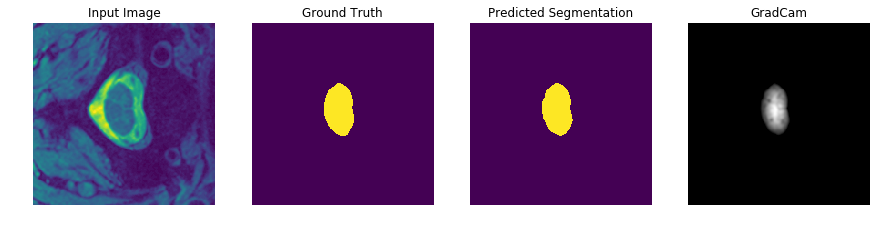

In [0]:
def gradcam_forward_hook(module, inp, out):
  """
  Function to store output feature maps in the forward pass.
    
  :param module: nn.Module onto which the hook is registered
  :inp: activations entering a layer of the module
  :out: activations exiting a layer of the module
  """
  # make the activations variable global
  global activations
  # store the feature maps
  activations=out
  
  
def gradcam_backward_hook(module, grad_inp, grad_out):
  """
  Function to store output gradients in the backward pass.
  
  :param module: nn.Module onto which the hook is registered
  :grad_inp: gradients entering a layer from behind the module
  :grad_out: gradients exiting a layer from the front of the module
  """
  # make the grads variable global
  global grads
  # store the gradients
  grads=grad_out  


def grad_cam(model, img, img_gt, layer_no=-1, size=(200,200), plot=True):
  """
  Function to find the Grad-CAM given an image in the desired layer.
    
  :param model (pytorch Unet): a trained model (pytorch)
  :param img (torch.tensor): preprocessed image with a tensor shape of (C,H,W)
  :param img_gt (torch.tensor): ground truth mask with a tensor shape of (C,H,W)
  :param layer_no (integer): desired layer index 
  :param size (tuple): the desired output image size
  :param plot(boolean): whether to plot
  """
  # make the activations and grads variable global
  global activations
  global grads

  # register forward and backward hooks on a desired layer in the model 
  f_hook=list(model.modules())[layer_no].register_forward_hook(gradcam_forward_hook) 
  b_hook=list(model.modules())[layer_no].register_backward_hook(gradcam_backward_hook)
    
  # zero out the existing gradient buffers
  model.zero_grad()
  
  # forward pass 
  scores=model(img)
  
  # predictions
  pred = threshold_predictions(scores.data.cpu().numpy()).astype(np.uint8).squeeze()
  
  # backward pass
  scores.sum().backward()
    
  # clear hooks
  f_hook.remove()
  b_hook.remove()
  
  # gradients and activations of the desired layer
  grads=grads[0].squeeze()
  activations=activations.squeeze()
  
  # global average pool the gradients to get neuron importance weights. This is the
  # most important part of gradcam, in which each of the pool-values represents 
  # the "importance/weight" of a forward feature map. The final gradcam visualization
  # will be the sum of the muliplication of these pool-values and their corresponding
  # feature maps.
  alphas=grads.mean(dim=2,keepdim=True).mean(dim=1,keepdim=True)

  # sum up the weighted combination of the weighted activations (by alphas)
  activations=activations.mul(alphas)           
  activations=activations.sum(dim=0,keepdim=True).squeeze()
  
  # follow the activations by a ReLU to obtain the heatmap of Grad-CAM
  heatmap=nn.ReLU()(activations)
  
  # normalize the heatmap
  heatmap-=heatmap.min()
  heatmap/=heatmap.max()
  
  # resize the heatmap to the input PIL image with bilinear interpolation to reach
  # the desired size. Need to convert to PIL image to use the resize function first
  heatmap=transforms.ToPILImage()(heatmap.cpu().detach())
  heatmap=transforms.Resize(size)(heatmap)
  heatmap=transforms.ToTensor()(heatmap).squeeze()
  
  if plot:
    # display the image and it's gradcam
    fig=plt.figure(figsize=(15, 15))
    
    # original image
    fig.add_subplot(1,4,1)
    plt.imshow(img.cpu().squeeze().detach())
    plt.title('Input Image')
    plt.axis('off') 
    
    # ground truth
    fig.add_subplot(1,4,2)
    plt.imshow(img_gt.squeeze().detach()) 
    plt.title('Ground Truth')
    plt.axis('off')
    
    # prediction
    fig.add_subplot(1,4,3)
    plt.imshow(pred) 
    plt.title('Predicted Segmentation')
    plt.axis('off')
   
    # gradcam
    fig.add_subplot(1,4,4)
    plt.imshow(heatmap.cpu(),cmap='gray') 
    plt.title('GradCam')
    plt.axis('off')
   
  return heatmap

# gradcam visualization
heatmap = grad_cam(model_t, img, img_gt, layer_no=-2)


#### Observation: Grad-CAM highlights the GM&WM regions in the visualization (instead of just the boundary). This indicates that the region with similar voxel intensity values may be one of the keys to predict a proper segmentation. 